In [1]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import compress_pickle

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'pc_clustering_210707'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData


['pc_0', 'pc_1', 'pc_15', 'pc_16', 'pc_17', 'pc_18', 'pc_19', 'pc_2', 'pc_21', 'pc_25', 'pc_26', 'pc_28', 'pc_32', 'pc_4', 'pc_43', 'pc_5', 'pc_50', 'pc_51', 'pc_57', 'pc_7', 'pc_9', 'purkinje_0', 'purkinje_1']
Height: 8.0, Aspect: 1.5


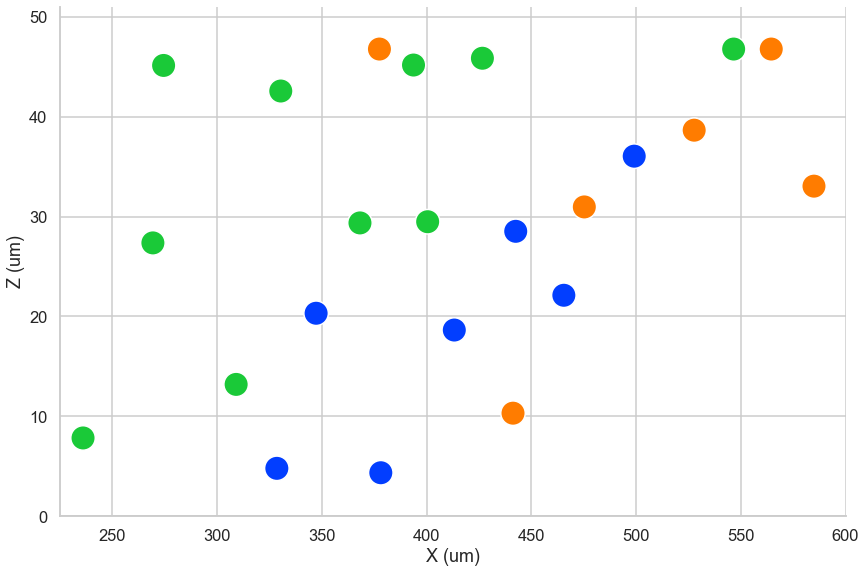

In [4]:

min_length = 30
n_clusters = 3
beta = 20
gamma = 1.5

# db = compress_pickle.load(
#     f'/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/grc_pc/'
#     f'grc_pc_pattern_similarity_210101_max_dist_150_min_length_{min_length}_paired_score_adj_beta_{beta}_gamma_{gamma}.gz')

# db = compress_pickle.load(
#     f'/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/grc_pc/'
#     f'pc_grc_pattern_similarity_210101_max_dist_150_min_length_{min_length}_paired_score_adj_beta_{beta}_gamma_{gamma}.gz')

db = compress_pickle.load(
    f'/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/grc_pc/'
    f'pc_grc_pattern_similarity_210101_max_dist_150_min_length_{min_length}_paired_score.gz')

pcs = sorted(db.keys())

valid_pcs = set()
for pc0 in pcs:
    for pc1 in pcs:
        if pc0 == pc1: continue
        if db[pc0][pc1] is not None:
            valid_pcs.add(pc0)
        
# # remove trivial pcs
# with open('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/db_pc_no_dendrites') as fin:
#     for line in fin:
#         line = line.strip()
#         valid_pcs.remove(line)
       

valid_pcs = sorted(list(valid_pcs))
print(valid_pcs)
            
X = []
for pc0 in valid_pcs:
    x = []
    for pc1 in valid_pcs:
        score = db[pc0][pc1]
        if score is None:
            score = 0.5
        x.append(score)
    X.append(x)

# X[0]

import sklearn
from sklearn.cluster import SpectralClustering
af =SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    random_state=5,
    n_init=100,
).fit(X)

# af.labels_


import my_plot
from my_plot import MyPlotData

mpd = MyPlotData()
labels = set()

for i, pc in enumerate(valid_pcs):
    if pc not in loc_db:
        print(f'skipping {pc}')
        continue
    loc = loc_db[pc]
    label = af.labels_[i]
    mpd.add_data_point(
#         x=loc[0]/16,
#         y=loc[1]/16,
#         z=loc[2]/40,
        x=loc[0]/4/1000,
        y=loc[1]/4/1000,
        z=loc[2]/1000,
        label=label,
        )
    labels.add(label)

n_colors = max(labels)

import seaborn as sns

# palette = sns.color_palette("hls", n_colors=35, as_cmap=True)
# palette = sns.color_palette("hls", n_colors=35, as_cmap=True)
# palette = sns.color_palette("Paired", max(af.labels_)+1)
# palette = sns.color_palette("Set1", max(af.labels_)+1)
# palette = sns.color_palette("Dark2", max(af.labels_)+1)
palette = sns.color_palette("bright", max(af.labels_)+1)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd,
    kind='scatter',
    x="x",
    y="z",
#     xlim=[50000, 160000],
#     xlim=[50000, 160000],
#     ylim=[0, 1200],
    xlim=[225, 600],
    ylim=[0, 51],
    aspect=1.5,
    width=12,
    s=600,
    hue="label",
    hue_order=sorted(labels),
    palette=palette,
    # alpha=.9,
    y_axis_label='Z (um)',
    x_axis_label='X (um)',
    legend=False,
    save_filename=f'{script_n}_min_length_{min_length}_n_clusters_{n_clusters}_beta_{beta}_gamma_{gamma}.svg',
    show=True,
    )


In [21]:
X[0]
af.labels_
# print(len(X))

array([1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2,
       0], dtype=int32)

In [35]:
af.labels_
clusters = defaultdict(list)
pc_to_cluster = dict()
pc_ids = []
for pc_id, cluster in enumerate(af.labels_):
    if cluster == 2: cluster = 1
    elif cluster == 1: cluster = 2
    clusters[cluster].append(pc_id)
    pc_to_cluster[pc_id] = cluster
    pc_ids.append(pc_id)
pc_ids_ordered = sorted(pc_ids, key=lambda x: pc_to_cluster[x])
print(pc_ids_ordered)
print(clusters)

[1, 2, 13, 15, 19, 20, 22, 4, 5, 7, 9, 10, 11, 12, 17, 18, 21, 0, 3, 6, 8, 14, 16]
defaultdict(<class 'list'>, {2: [0, 3, 6, 8, 14, 16], 0: [1, 2, 13, 15, 19, 20, 22], 1: [4, 5, 7, 9, 10, 11, 12, 17, 18, 21]})


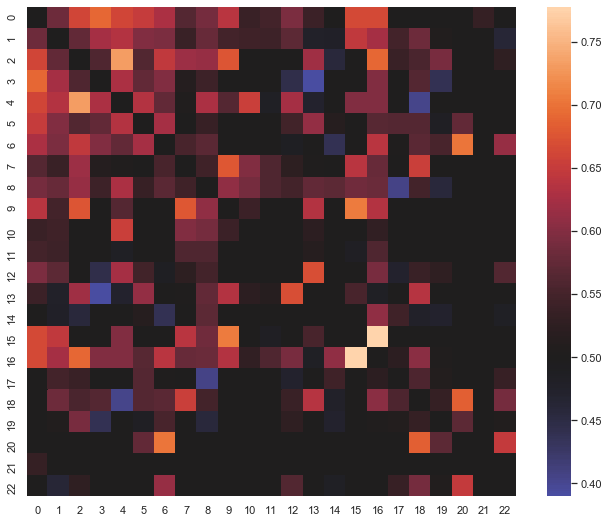

In [32]:
pc_ids_ordered = [1, 2, 13, 15, 19, 20, 22, 4, 5, 7, 9, 10, 11, 12, 17, 18, 21, 0, 3, 6, 8, 14, 16]
sim_matrix = []
for i in pc_ids_ordered:
    row = []
    for j in pc_ids_ordered:
        if i == j:
            row.append(.5)
            continue
        row.append(X[i][j])
    sim_matrix.append(row)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(sim_matrix,
            center=.5,
#             vmax=5,
            square=True,
           )

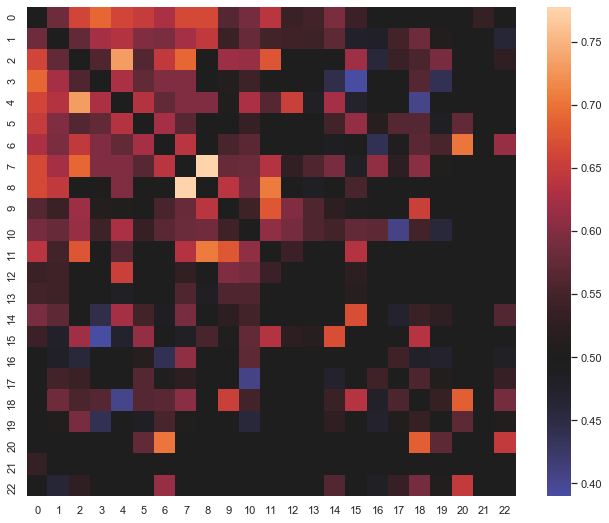

In [41]:
pc_ids_ordered_mod = copy.copy(pc_ids_ordered)
a = pc_ids_ordered_mod.pop(15)
b = pc_ids_ordered_mod.pop(15)
pc_ids_ordered_mod.insert(7, a)
pc_ids_ordered_mod.insert(7, b)
sim_matrix = []
for i in pc_ids_ordered_mod:
    row = []
    for j in pc_ids_ordered_mod:
        if i == j:
            row.append(.5)
            continue
        row.append(X[i][j])
    sim_matrix.append(row)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(sim_matrix,
            center=.5,
#             vmax=5,
            square=True,
           )

In [18]:

for label in set(af.labels_):
    print(f'label: {label}')
    for i, pc in enumerate(valid_pcs):
        if af.labels_[i] != label:
            continue
        print(pc)


label: 0
pc_1
pc_15
pc_4
pc_5
pc_7
pc_9
purkinje_1
label: 1
pc_0
pc_16
pc_19
pc_21
pc_43
pc_50
label: 2
pc_17
pc_18
pc_2
pc_25
pc_26
pc_28
pc_32
pc_51
pc_57
purkinje_0


In [3]:
import tools2

loc_db = compress_pickle.load(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pc_soma_locs.gz')

def to_ng_coord(coord):
    return (
        int(coord[0]/16),
        int(coord[1]/16),
        int(coord[2]/40),
        )

for label in set(af.labels_):
    print(f'label: {label}')
    for i, pc in enumerate(valid_pcs):
        if af.labels_[i] != label:
            continue
        if pc not in loc_db:
            print(f'skipping {pc}')
            continue
        print(f'{pc}: {to_ng_coord(loc_db[pc])}')


label: 0
pc_1: (86821, 97570, 508)
pc_15: (110643, 93711, 713)
pc_4: (103311, 94989, 466)
pc_5: (94541, 97952, 109)
pc_7: (82134, 96760, 120)
pc_9: (124782, 92871, 901)
purkinje_1: (116385, 93870, 553)
label: 1
pc_0: (110319, 95553, 258)
pc_16: (118827, 92848, 774)
pc_19: (131939, 92568, 966)
pc_21: (146236, 91948, 826)
pc_43: (94378, 70328, 1169)
pc_50: (141136, 89838, 1169)
label: 2
pc_17: (82603, 95590, 1064)
pc_18: (100133, 94722, 737)
pc_2: (77277, 96697, 330)
pc_25: (68620, 97798, 1128)
pc_26: (67342, 97175, 684)
pc_28: (106666, 92867, 1146)
pc_32: (98444, 92975, 1129)
pc_51: (136650, 90564, 1169)
pc_57: (59005, 97577, 196)
purkinje_0: (92054, 96470, 734)


Height: 4, Aspect: 0.75


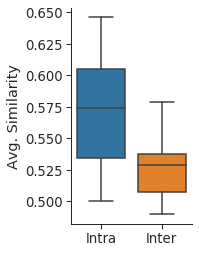

In [52]:
# calculate inter vs intra cluster similarity

intra_similarity = []
inter_similarity = []
intra_similarity2 = []
inter_similarity2 = []
intra_similarity_per_pc = defaultdict(list)
inter_similarity_per_pc = defaultdict(list)

for i, pc0 in enumerate(valid_pcs):
    for j, pc1 in enumerate(valid_pcs):
        if i == j:
            continue
        score = db[pc0][pc1]
        if score is None:
#             continue
            score = 0.5
        if af.labels_[i] != af.labels_[j]:
            inter_similarity_per_pc[i].append(score)
            inter_similarity2.append(score)
        else:
            intra_similarity_per_pc[i].append(score)
            intra_similarity2.append(score)

mpd = MyPlotData()        
for k, l in intra_similarity_per_pc.items():
    intra_similarity.append(sum(l)/len(l))
    mpd.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Intra',
    )
for k, l in inter_similarity_per_pc.items():
    inter_similarity.append(sum(l)/len(l))
    mpd.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Inter',
    )

mpd2 = MyPlotData()        
for v in intra_similarity2:
    mpd2.add_data_point(
        avg_similarity=v,
        group='Intra',
    )     
for v in inter_similarity2:
    mpd2.add_data_point(
        avg_similarity=v,
        group='Inter',
    )


importlib.reload(my_plot); my_plot.my_catplot(
    mpd,
    x="group",
    y="avg_similarity",
#     hue="group",
#     ylim=[0, 1],
#     ylim=[.35, .8],
    context='paper',
    kind='box',
    height=4,
    width=3,
    y_axis_label='Avg. Similarity',
    # x_axis_label='# of synapses per connection',
#     save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )

Height: 4, Aspect: 1.25


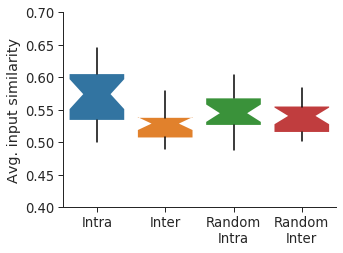

In [53]:
# calculate inter vs intra cluster similarity

intra_similarity_random = []
inter_similarity_random = []
intra_similarity_per_pc = defaultdict(list)
inter_similarity_per_pc = defaultdict(list)

random.seed(2)
random_labels = {}
for i, pc0 in enumerate(valid_pcs):
    random_labels[i] = random.randint(0, 2)

for i, pc0 in enumerate(valid_pcs):
    for j, pc1 in enumerate(valid_pcs):
        if i == j:
            continue
        score = db[pc0][pc1]
        if score is None:
            score = 0.5
        if random_labels[i] != random_labels[j]:
            inter_similarity_per_pc[i].append(score)
        else:
            intra_similarity_per_pc[i].append(score)

mpd_random = MyPlotData()
    
for k, l in intra_similarity_per_pc.items():
    intra_similarity_random.append(sum(l)/len(l))
    mpd_random.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Random\nIntra',
    )
for k, l in inter_similarity_per_pc.items():
    inter_similarity_random.append(sum(l)/len(l))
    mpd_random.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Random\nInter',
    )

mpd_all = MyPlotData()
mpd_all.append(mpd)
mpd_all.append(mpd_random)

color = dict(boxes='black', whiskers='black', medians='red', caps='black')
whiskerprops = dict(linestyle='-',linewidth=1.5, color='black')
meanprops = dict(linestyle='-',linewidth=1, color='black')

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="group",
    y="avg_similarity",
#     hue="group",
    ylim=[.4, .7],
    context='paper',
    kind='box',
    height=4,
    width=5,
    linewidth=0,
    y_axis_label='Avg. input similarity',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_inter_vs_intra.svg',
    show=True,
    notch=True,
    whiskerprops=whiskerprops,
#     medianprops=meanprops,
    )


In [60]:
import scipy
print('\nIntra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity, intra_similarity_random))
print('\nInter-cluster avg. similarity:')
print(scipy.stats.ranksums(inter_similarity, inter_similarity_random))
print('\nInter- vs intra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity, inter_similarity))
print('\nRANDOM Inter- vs intra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity_random, inter_similarity_random))


Intra-cluster avg. similarity:
RanksumsResult(statistic=3.8312473246008274, pvalue=0.0001274952644776224)

Inter-cluster avg. similarity:
RanksumsResult(statistic=-2.679132100978654, pvalue=0.0073813266938361445)

Inter- vs intra-cluster avg. similarity:
RanksumsResult(statistic=3.6798377420515282, pvalue=0.00023338240387325068)

RANDOM Inter- vs intra-cluster avg. similarity:
RanksumsResult(statistic=-1.4610971625055058, pvalue=0.14398877882348976)


In [59]:
print(len(intra_similarity))
print(len(inter_similarity))
print(len(intra_similarity_random))
print(len(inter_similarity_random))

23
23
805
805


In [56]:

print(scipy.stats.kruskal(intra_similarity, inter_similarity, intra_similarity_random, inter_similarity_random))
import scikit_posthocs
scikit_posthocs.posthoc_dunn([intra_similarity, inter_similarity, intra_similarity_random, inter_similarity_random], p_adjust='bonferroni')


KruskalResult(statistic=17.0491282736854, pvalue=0.0006904886998727849)


,1,2,3,4
1,1.000000,0.000260,0.221205,0.069181
2,0.000260,1.000000,0.271941,0.708796
3,0.221205,0.271941,1.000000,1.000000
4,0.069181,0.708796,1.000000,1.000000


In [57]:

print(scipy.stats.kruskal(intra_similarity, inter_similarity, intra_similarity_random))
import scikit_posthocs
scikit_posthocs.posthoc_dunn([intra_similarity, inter_similarity, inter_similarity_random], p_adjust='bonferroni')


KruskalResult(statistic=14.983746585575664, pvalue=0.000557597438241004)


,1,2,3
1,1.000000,0.000164,0.043183
2,0.000164,1.000000,0.337253
3,0.043183,0.337253,1.000000


In [58]:
# run multiple random shuffles

intra_similarity_random = []
inter_similarity_random = []
mpd_random = MyPlotData()
for n_run in range(35):
    intra_similarity_per_pc = defaultdict(list)
    inter_similarity_per_pc = defaultdict(list)

    random.seed(n_run)
    random_labels = {}
    for i, pc0 in enumerate(valid_pcs):
        random_labels[i] = random.randint(0, 2)

    for i, pc0 in enumerate(valid_pcs):
        for j, pc1 in enumerate(valid_pcs):
            if i == j:
                continue
            score = db[pc0][pc1]
            if score is None:
                score = 0.5
            if random_labels[i] != random_labels[j]:
                inter_similarity_per_pc[i].append(score)
            else:
                intra_similarity_per_pc[i].append(score)

    for k, l in intra_similarity_per_pc.items():
        intra_similarity_random.append(sum(l)/len(l))
        mpd_random.add_data_point(
            avg_similarity=sum(l)/len(l),
            group='Random\nIntra',
        )
    for k, l in inter_similarity_per_pc.items():
        inter_similarity_random.append(sum(l)/len(l))
        mpd_random.add_data_point(
            avg_similarity=sum(l)/len(l),
            group='Random\nInter',
        )
    print(f'{n_run}..', end='')


0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..

Height: 4, Aspect: 1.25


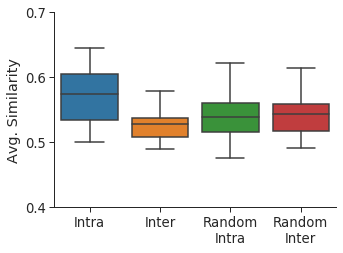

In [12]:

mpd_all = MyPlotData()
mpd_all.append(mpd)
mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="group",
    y="avg_similarity",
#     hue="group",
    ylim=[.4, .7],
    y_tick_interval=.1,
    context='paper',
    kind='box',
    height=4,
    width=5,
    y_axis_label='Avg. Similarity',
    # x_axis_label='# of synapses per connection',
#     save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )
